In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri, default_converter

np_cv_rules = default_converter + numpy2ri.converter

In [3]:
utils = importr('utils')
base = importr('base')
sn = importr('sn')
ks = importr('ks')
copula = importr('copula')

In [4]:
import sys
sys.path.append("../") # go to parent dir

In [5]:
dat = pd.read_csv('../data/FlowData.csv')
dat = dat / 10000
dat.head()

,Flow1,Flow2,Flow3
0,113.0118,221.7628,41.9489
1,110.5125,221.7628,39.1512
2,74.5276,221.7628,22.7725
3,69.8220,221.7628,23.0217
4,77.8948,221.7629,19.2731


In [6]:
def to_uniform(x):
    with np_cv_rules.context():
        fit = sn.st_mple(y=x.values, dp=np.array([np.mean(x), np.std(x, ddof=1), 0, 10]))
        est = fit['dp']
        return sn.pst(x.values, dp=est)

In [7]:
u1 = to_uniform(dat['Flow1'])
u2 = to_uniform(dat['Flow2'])
U_hat = np.hstack([u1.reshape(-1, 1), u2.reshape(-1, 1)])
Z_hat = stats.norm.ppf(U_hat)

In [8]:
U_hat_r = numpy2ri.converter.py2rpy(U_hat)
f_hat_U = ks.kde(x=U_hat_r, H=ks.Hscv(x=U_hat_r))
cont_levels_pct = np.arange(10, 90, 10)
with np_cv_rules.context():
    cont_levels = ks.contourLevels(f_hat_U, cont=cont_levels_pct)
    f_hat_U = base.identity(f_hat_U)

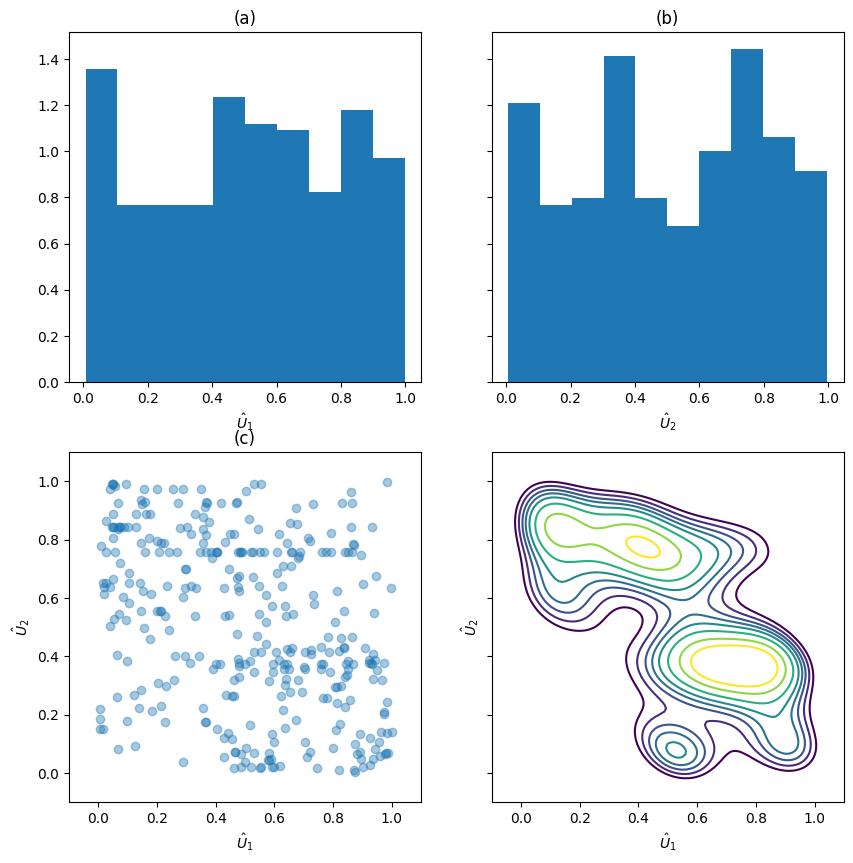

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey='row', sharex='row')

axs[0][0].hist(u1, density=True);
axs[0][0].set_title('(a)');
axs[0][0].set_xlabel('$\\hat{U}_1$');

axs[0][1].hist(u2, density=True);
axs[0][1].set_title('(b)');
axs[0][1].set_xlabel('$\\hat{U}_2$');

axs[1][0].scatter(u1, u2, alpha=0.4);
axs[1][0].set_title('(c)');
axs[1][0].set_xlabel('$\\hat{U}_1$');
axs[1][0].set_ylabel('$\\hat{U}_2$');

axs[1][1].contour(f_hat_U['eval.points'].byindex(0)[1], f_hat_U['eval.points'].byindex(1)[1], f_hat_U['estimate'].T, levels=np.sort(cont_levels));
axs[1][1].set_xlabel('$\\hat{U}_1$');
axs[1][1].set_ylabel('$\\hat{U}_2$');
axs[1][1].set_xlim([-0.1, 1.1]);
axs[1][1].set_ylim([-0.1, 1.1]);

In [10]:
Z_hat_r = numpy2ri.converter.py2rpy(Z_hat)
f_hat_Z = ks.kde(x=Z_hat_r, H=ks.Hscv(x=Z_hat_r))
with np_cv_rules.context():
    cont_levels = ks.contourLevels(f_hat_Z, cont=cont_levels_pct)
    f_hat_Z = base.identity(f_hat_Z)

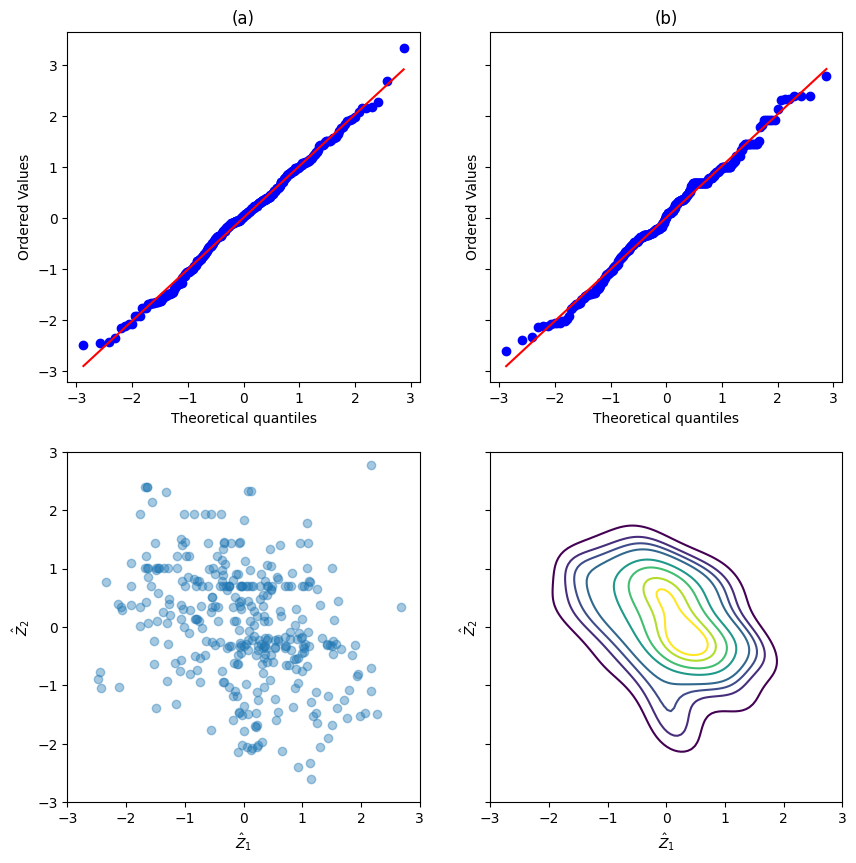

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey='row', sharex='row')

stats.probplot(Z_hat[:, 0], dist="norm", plot=axs[0][0]);
axs[0][0].set_title('(a)');

stats.probplot(Z_hat[:, 1], dist="norm", plot=axs[0][1]);
axs[0][1].set_title('(b)');

axs[1][0].scatter(Z_hat[:, 0], Z_hat[:, 1], alpha=0.4);
axs[1][0].set_xlabel('$\\hat{Z}_1$');
axs[1][0].set_ylabel('$\\hat{Z}_2$');

axs[1][1].contour(f_hat_Z['eval.points'].byindex(0)[1], f_hat_Z['eval.points'].byindex(1)[1], f_hat_Z['estimate'].T, levels=np.sort(cont_levels));
axs[1][1].set_xlabel('$\\hat{Z}_1$');
axs[1][1].set_ylabel('$\\hat{Z}_2$');
axs[1][1].set_xlim([-3.0, 3.0]);
axs[1][1].set_ylim([-3.0, 3.0]);

In [12]:
stats.spearmanr(u1, u2)

SignificanceResult(statistic=-0.35701803426536477, pvalue=1.0191616692469447e-11)

In [13]:
tau = stats.kendalltau(u1, u2)
tau

SignificanceResult(statistic=-0.24245718521857987, pvalue=2.790188046345114e-11)

In [14]:
omega = np.sin(tau.statistic * math.pi / 2)
omega

-0.3717104948799989

In [15]:
np.corrcoef(u1, u2)[0, 1]

-0.35874054935534094

In [16]:
np.corrcoef(Z_hat[:, 0], Z_hat[:, 1])[0, 1]

-0.33522111944440747

In [17]:
from ch8.utils import fit_copula, plot_copula, plot_empirical_copula

In [18]:
C_t = fit_copula(copula.tCopula(dim=2), [omega, 10], U_hat)
C_t

(array([-0.3401385 , 22.44679819]), -37.9654510136057)

In [19]:
C_norm = fit_copula(copula.normalCopula(dim=2), [omega], U_hat)
C_norm

(array([-0.3306667]), -38.72113837782534)

In [20]:
C_frank = fit_copula(copula.frankCopula(1, dim=2), None, U_hat) 
C_frank

(array([-2.24935912]), -44.13555253632079)

In [21]:
C_clayton = fit_copula(copula.claytonCopula(1, dim=2), None, U_hat) 
C_clayton

(array([-0.16650618]), -17.74171718105902)

In [22]:
n = 200  # len(u1)
xs = (np.arange(1, n + 1) / (n + 1))
grid = np.vstack([np.repeat(xs, n), np.tile(xs, n)]).T

In [23]:
# calculate the empirical copula
with np_cv_rules.context():
    Cn = copula.C_n(u=grid, X=U_hat)
    zs = Cn.reshape((n, n)).T

In [24]:
levels = np.arange(1, 10) / 10

In [27]:
def plot_copula_comparison(ax, copula_def, title):
    plot_empirical_copula(ax, xs, xs, zs, levels)
    plot_copula(ax, copula_def, xs, levels, copula.pCopula);
    ax.set_title(title);

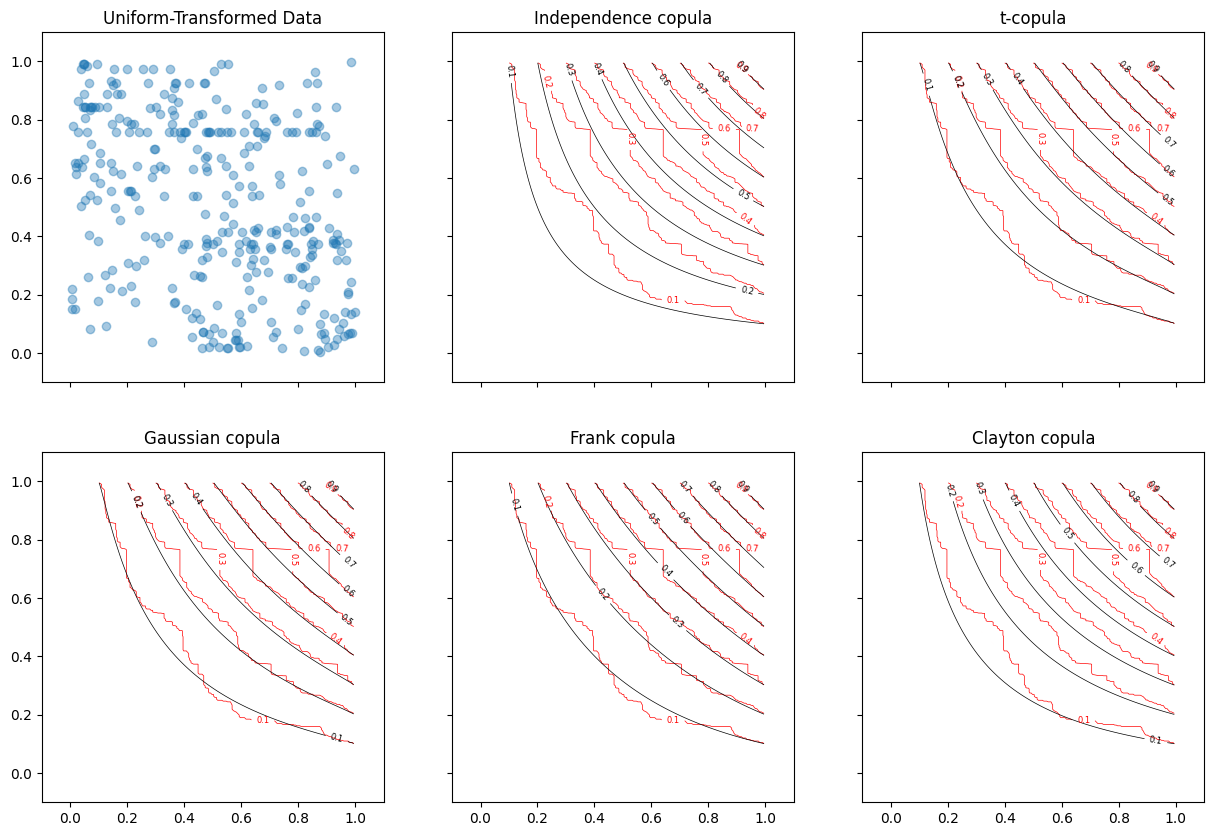

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

axs[0][0].scatter(u1, u2, alpha=0.4)
axs[0][0].set_title('Uniform-Transformed Data');
axs[0][0].set_xlim([-0.1, 1.1]);
axs[0][0].set_ylim([-0.1, 1.1]);

ax = axs[0][1]
plot_empirical_copula(ax, xs, xs, zs, levels)
plot_copula(ax, copula.normalCopula(param=0, dim=2), xs, levels, copula.pCopula);
ax.set_title('Independence copula');

plot_copula_comparison(
    axs[0][2],
    copula.tCopula(param=numpy2ri.converter.py2rpy(C_t[0][0]), dim=2, df=numpy2ri.converter.py2rpy(np.round(C_t[0][1]))),
    't-copula',
)

plot_copula_comparison(
    axs[1][0],
    copula.normalCopula(param=numpy2ri.converter.py2rpy(C_norm[0][0]), dim=2),
    'Gaussian copula',
)

plot_copula_comparison(
    axs[1][1],
    copula.frankCopula(param=numpy2ri.converter.py2rpy(C_frank[0][0]), dim=2),
    'Frank copula',
)

plot_copula_comparison(
    axs[1][2],
    copula.claytonCopula(param=numpy2ri.converter.py2rpy(C_clayton[0][0]), dim=2),
    'Clayton copula',
)